In [1]:
import os
import glob
import gc
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Check GPU
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU Memory: {gpu_mem:.1f} GB")

PyTorch: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.8 GB


In [2]:
BASE_PATH = "/kaggle/input/pixel-play-26"
DATA_ROOT = os.path.join(BASE_PATH, os.listdir(BASE_PATH)[0])
AVENUE_PATH = os.path.join(DATA_ROOT, "Avenue_Corrupted", "Dataset")

TRAIN_VIDEOS = os.path.join(AVENUE_PATH, "training_videos")
TEST_VIDEOS = os.path.join(AVENUE_PATH, "testing_videos")
OUTPUT_DIR = "/kaggle/working"

# Verify paths
print(f"Train path exists: {os.path.exists(TRAIN_VIDEOS)}")
print(f"Test path exists: {os.path.exists(TEST_VIDEOS)}")

Train path exists: True
Test path exists: True


In [3]:
CONFIG = {
    # Data
    'image_size': (128, 128),
    
    # Model
    'latent_dim': 512,
    
    # Training
    'batch_size': 64,           # Larger batch since data is on GPU
    'num_epochs': 50,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    
    # Loss weights
    'lambda_mse': 1.0,
    'lambda_ssim': 0.5,
    'lambda_gradient': 0.2,
    
    # Scoring
    'temporal_window': 5,
    
    # Reproducibility
    'seed': 42,
}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set seeds
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['seed'])
    torch.backends.cudnn.deterministic = False  # Faster
    torch.backends.cudnn.benchmark = True       # Optimize for fixed input size

print(f"Device: {DEVICE}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Epochs: {CONFIG['num_epochs']}")

Device: cuda
Batch size: 64
Epochs: 50


In [4]:
def discover_frames(video_dir):
    """Discover all frames, handling 'frame_XXXXX.jpg' naming."""
    frames = defaultdict(list)
    
    if not os.path.exists(video_dir):
        print(f"ERROR: {video_dir} not found!")
        return frames
    
    for vf in sorted(glob.glob(os.path.join(video_dir, '*'))):
        if not os.path.isdir(vf):
            continue
        
        try:
            vid = int(os.path.basename(vf))
        except ValueError:
            continue
        
        for ff in sorted(glob.glob(os.path.join(vf, '*.jpg'))):
            fname = os.path.splitext(os.path.basename(ff))[0]
            
            # Handle "frame_XXXXX" format
            if fname.startswith('frame_'):
                fname = fname.replace('frame_', '')
            
            try:
                fnum = int(fname)
                frames[vid].append((fnum, ff))
            except ValueError:
                continue
        
        frames[vid].sort(key=lambda x: x[0])
    
    return dict(frames)

In [5]:
print("Discovering frames...")
train_frames = discover_frames(TRAIN_VIDEOS)
test_frames = discover_frames(TEST_VIDEOS)

total_train = sum(len(v) for v in train_frames.values())
total_test = sum(len(v) for v in test_frames.values())

print(f"Train: {len(train_frames)} videos, {total_train} frames")
print(f"Test: {len(test_frames)} videos, {total_test} frames")

# Estimate memory
est_train_gb = total_train * 128 * 128 * 3 * 4 / 1e9
est_test_gb = total_test * 128 * 128 * 3 * 4 / 1e9
print(f"\nEstimated GPU memory: {est_train_gb + est_test_gb:.2f} GB")

Discovering frames...
Train: 16 videos, 9204 frames
Test: 21 videos, 11706 frames

Estimated GPU memory: 4.11 GB


In [6]:
test_frame_ids = []
test_frame_info = []

for vid in sorted(test_frames.keys()):
    for fnum, _ in test_frames[vid]:
        test_frame_ids.append(f"{vid}_{fnum}")
        test_frame_info.append((vid, fnum))

print(f"Test frame IDs: {len(test_frame_ids)}")
print(f"Sample: {test_frame_ids[:5]}")

Test frame IDs: 11706
Sample: ['1_939', '1_940', '1_941', '1_942', '1_943']


In [7]:
def load_all_frames_to_gpu(frames_dict, image_size, device, desc="Loading"):
    """
    Load all frames directly to GPU as a single tensor.
    This is the KEY optimization - zero CPU-GPU transfer during training.
    """
    total = sum(len(v) for v in frames_dict.values())
    H, W = image_size
    
    # Allocate tensor on GPU
    all_frames = torch.zeros(total, 3, H, W, dtype=torch.float32, device=device)
    frame_info = []
    
    idx = 0
    pbar = tqdm(total=total, desc=desc)
    
    for vid in sorted(frames_dict.keys()):
        for fnum, path in frames_dict[vid]:
            # Load and preprocess
            img = Image.open(path).convert('RGB')
            img = img.resize((W, H), Image.BILINEAR)
            
            # Convert to tensor: [0, 255] -> [-1, 1]
            arr = np.array(img, dtype=np.float32)
            arr = arr / 127.5 - 1.0
            
            # Move to GPU
            tensor = torch.from_numpy(arr).permute(2, 0, 1)
            all_frames[idx] = tensor.to(device)
            
            frame_info.append((vid, fnum))
            idx += 1
            pbar.update(1)
    
    pbar.close()
    
    # Force garbage collection
    gc.collect()
    
    return all_frames, frame_info

In [8]:
print("Loading TRAINING data to GPU...")
start_time = time.time()

train_tensors, train_info = load_all_frames_to_gpu(
    train_frames, CONFIG['image_size'], DEVICE, "Train→GPU"
)

print(f"\nTrain tensor: {train_tensors.shape}")
print(f"Dtype: {train_tensors.dtype}")
print(f"Device: {train_tensors.device}")
print(f"Load time: {time.time() - start_time:.1f}s")
print(f"GPU memory used: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

Loading TRAINING data to GPU...


Train→GPU:   0%|          | 0/9204 [00:00<?, ?it/s]


Train tensor: torch.Size([9204, 3, 128, 128])
Dtype: torch.float32
Device: cuda:0
Load time: 104.6s
GPU memory used: 1.81 GB


In [9]:
print("Loading TESTING data to GPU...")
start_time = time.time()

test_tensors, test_info = load_all_frames_to_gpu(
    test_frames, CONFIG['image_size'], DEVICE, "Test→GPU"
)

print(f"\nTest tensor: {test_tensors.shape}")
print(f"Load time: {time.time() - start_time:.1f}s")
print(f"Total GPU memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

# Verify frame order matches
assert test_info == test_frame_info, "Frame order mismatch!"
print("\n✓ Frame order verified!")

Loading TESTING data to GPU...


Test→GPU:   0%|          | 0/11706 [00:00<?, ?it/s]


Test tensor: torch.Size([11706, 3, 128, 128])
Load time: 137.4s
Total GPU memory: 4.11 GB

✓ Frame order verified!


In [10]:
class GPUTensorDataset(Dataset):
    """Dataset for tensors already on GPU."""
    def __init__(self, tensors, frame_info=None):
        self.tensors = tensors
        self.frame_info = frame_info
    
    def __len__(self):
        return len(self.tensors)
    
    def __getitem__(self, idx):
        if self.frame_info:
            vid, fnum = self.frame_info[idx]
            return self.tensors[idx], vid, fnum
        return self.tensors[idx]

# Create datasets
train_dataset = GPUTensorDataset(train_tensors)
test_dataset = GPUTensorDataset(test_tensors, test_info)

# DataLoaders - no workers needed since data is on GPU
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True,
    num_workers=0,
    pin_memory=False  # Already on GPU
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"Train: {len(train_loader)} batches of {CONFIG['batch_size']}")
print(f"Test: {len(test_loader)} batches")

Train: 144 batches of 64
Test: 183 batches


In [11]:
# Benchmark dataloader
print("Benchmarking dataloader...")

torch.cuda.synchronize()
start = time.time()

for i, batch in enumerate(train_loader):
    if i >= 20:
        break
    # Data is already on GPU - no transfer needed
    _ = batch

torch.cuda.synchronize()
elapsed = time.time() - start

print(f"20 batches in {elapsed*1000:.1f}ms")
print(f"Per batch: {elapsed/20*1000:.2f}ms")
print("\n✓ This should be <5ms per batch (pure GPU)")

Benchmarking dataloader...
20 batches in 164.2ms
Per batch: 8.21ms

✓ This should be <5ms per batch (pure GPU)


In [12]:
class UNetAutoencoder(nn.Module):
    """
    U-Net style autoencoder with skip connections.
    Better gradient flow and detail preservation.
    """
    def __init__(self, latent_dim=512):
        super().__init__()
        
        # Encoder blocks
        self.enc1 = self._make_enc_block(3, 64)      # 128→64
        self.enc2 = self._make_enc_block(64, 128)    # 64→32
        self.enc3 = self._make_enc_block(128, 256)   # 32→16
        self.enc4 = self._make_enc_block(256, 512)   # 16→8
        self.enc5 = self._make_enc_block(512, 512)   # 8→4
        
        # Bottleneck
        self.fc_encode = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, latent_dim),
            nn.LeakyReLU(0.2)
        )
        self.fc_decode = nn.Sequential(
            nn.Linear(latent_dim, 512 * 4 * 4),
            nn.LeakyReLU(0.2)
        )
        
        # Decoder blocks with skip connections
        self.dec5 = self._make_dec_block(512, 512)       # 4→8
        self.dec4 = self._make_dec_block(1024, 256)      # 8→16 (512+512 skip)
        self.dec3 = self._make_dec_block(512, 128)       # 16→32 (256+256 skip)
        self.dec2 = self._make_dec_block(256, 64)        # 32→64 (128+128 skip)
        self.dec1 = self._make_dec_block(128, 64)        # 64→128 (64+64 skip)
        
        # Output
        self.output = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _make_enc_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True),
        )
    
    def _make_dec_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)    # 64x64
        e2 = self.enc2(e1)   # 32x32
        e3 = self.enc3(e2)   # 16x16
        e4 = self.enc4(e3)   # 8x8
        e5 = self.enc5(e4)   # 4x4
        
        # Bottleneck
        z = self.fc_encode(e5)
        d = self.fc_decode(z).view(-1, 512, 4, 4)
        
        # Decoder with skip connections
        d = self.dec5(d)                          # 8x8
        d = self.dec4(torch.cat([d, e4], dim=1))  # 16x16
        d = self.dec3(torch.cat([d, e3], dim=1))  # 32x32
        d = self.dec2(torch.cat([d, e2], dim=1))  # 64x64
        d = self.dec1(torch.cat([d, e1], dim=1))  # 128x128
        
        return self.output(d)

In [13]:
model = UNetAutoencoder(latent_dim=CONFIG['latent_dim']).to(DEVICE)

# Count parameters
n_params = sum(p.numel() for p in model.parameters())
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {n_params:,}")
print(f"Trainable: {n_trainable:,}")

# Test forward pass
with torch.no_grad():
    test_input = torch.randn(2, 3, 128, 128, device=DEVICE)
    test_output = model(test_input)
    print(f"\nForward pass: {test_input.shape} → {test_output.shape}")
    print("✓ Model OK")

Total parameters: 33,852,355
Trainable: 33,852,355

Forward pass: torch.Size([2, 3, 128, 128]) → torch.Size([2, 3, 128, 128])
✓ Model OK


In [14]:
class SSIMLoss(nn.Module):
    """Structural Similarity Loss - better perceptual quality."""
    def __init__(self, window_size=11, channel=3):
        super().__init__()
        self.window_size = window_size
        self.channel = channel
        self.window = self._create_window(window_size, channel)
    
    def _gaussian(self, window_size, sigma=1.5):
        x = torch.arange(window_size).float() - window_size // 2
        gauss = torch.exp(-x.pow(2) / (2 * sigma ** 2))
        return gauss / gauss.sum()
    
    def _create_window(self, window_size, channel):
        _1D_window = self._gaussian(window_size).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        return window
    
    def forward(self, img1, img2):
        # Move window to same device
        if self.window.device != img1.device:
            self.window = self.window.to(img1.device)
        
        mu1 = F.conv2d(img1, self.window, padding=self.window_size//2, groups=self.channel)
        mu2 = F.conv2d(img2, self.window, padding=self.window_size//2, groups=self.channel)
        
        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2
        
        sigma1_sq = F.conv2d(img1*img1, self.window, padding=self.window_size//2, groups=self.channel) - mu1_sq
        sigma2_sq = F.conv2d(img2*img2, self.window, padding=self.window_size//2, groups=self.channel) - mu2_sq
        sigma12 = F.conv2d(img1*img2, self.window, padding=self.window_size//2, groups=self.channel) - mu1_mu2
        
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2
        
        ssim_map = ((2*mu1_mu2 + C1) * (2*sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        
        return 1 - ssim_map.mean()

In [15]:
class GradientLoss(nn.Module):
    """Edge preservation loss."""
    def __init__(self):
        super().__init__()
    
    def forward(self, pred, target):
        # Horizontal gradients
        pred_dx = pred[:, :, :, 1:] - pred[:, :, :, :-1]
        target_dx = target[:, :, :, 1:] - target[:, :, :, :-1]
        
        # Vertical gradients
        pred_dy = pred[:, :, 1:, :] - pred[:, :, :-1, :]
        target_dy = target[:, :, 1:, :] - target[:, :, :-1, :]
        
        loss_dx = F.l1_loss(pred_dx, target_dx)
        loss_dy = F.l1_loss(pred_dy, target_dy)
        
        return loss_dx + loss_dy

In [16]:
class CombinedLoss(nn.Module):
    """MSE + SSIM + Gradient loss."""
    def __init__(self, lambda_mse=1.0, lambda_ssim=0.5, lambda_grad=0.2):
        super().__init__()
        self.mse = nn.MSELoss()
        self.ssim = SSIMLoss()
        self.gradient = GradientLoss()
        
        self.lambda_mse = lambda_mse
        self.lambda_ssim = lambda_ssim
        self.lambda_grad = lambda_grad
    
    def forward(self, pred, target):
        loss_mse = self.mse(pred, target)
        loss_ssim = self.ssim(pred, target)
        loss_grad = self.gradient(pred, target)
        
        total = (self.lambda_mse * loss_mse + 
                 self.lambda_ssim * loss_ssim + 
                 self.lambda_grad * loss_grad)
        
        return total, {'mse': loss_mse.item(), 'ssim': loss_ssim.item(), 'grad': loss_grad.item()}

criterion = CombinedLoss(
    lambda_mse=CONFIG['lambda_mse'],
    lambda_ssim=CONFIG['lambda_ssim'],
    lambda_grad=CONFIG['lambda_gradient']
)
print("Loss: MSE + SSIM + Gradient")

Loss: MSE + SSIM + Gradient


In [17]:
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    betas=(0.9, 0.999)
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

print(f"Optimizer: AdamW (lr={CONFIG['learning_rate']})")
print(f"Scheduler: CosineAnnealingWarmRestarts")

Optimizer: AdamW (lr=0.001)
Scheduler: CosineAnnealingWarmRestarts


In [18]:
print("=" * 60)
print("STARTING TRAINING")
print("=" * 60)
print(f"Epochs: {CONFIG['num_epochs']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Batches per epoch: {len(train_loader)}")
print("=" * 60)

history = {
    'loss': [], 'mse': [], 'ssim': [], 'grad': [],
    'time': [], 'lr': []
}

best_loss = float('inf')
start_total = time.time()

for epoch in range(CONFIG['num_epochs']):
    model.train()
    epoch_loss = 0
    epoch_mse = 0
    epoch_ssim = 0
    epoch_grad = 0
    
    epoch_start = time.time()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']}", leave=False)
    for batch in pbar:
        # Get data (already on GPU!)
        if isinstance(batch, (list, tuple)):
            frames = batch[0]
        else:
            frames = batch
        
        # Forward
        optimizer.zero_grad(set_to_none=True)  # Faster than zero_grad()
        recon = model(frames)
        loss, loss_dict = criterion(recon, frames)
        
        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Track losses
        epoch_loss += loss.item()
        epoch_mse += loss_dict['mse']
        epoch_ssim += loss_dict['ssim']
        epoch_grad += loss_dict['grad']
        
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    scheduler.step()
    
    # Compute averages
    n_batches = len(train_loader)
    avg_loss = epoch_loss / n_batches
    avg_mse = epoch_mse / n_batches
    avg_ssim = epoch_ssim / n_batches
    avg_grad = epoch_grad / n_batches
    epoch_time = time.time() - epoch_start
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['loss'].append(avg_loss)
    history['mse'].append(avg_mse)
    history['ssim'].append(avg_ssim)
    history['grad'].append(avg_grad)
    history['time'].append(epoch_time)
    history['lr'].append(current_lr)
    
    # Track best
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pth'))
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {avg_loss:.5f} | "
              f"MSE: {avg_mse:.5f} | SSIM: {avg_ssim:.5f} | "
              f"Time: {epoch_time:.1f}s | LR: {current_lr:.6f}")

total_time = time.time() - start_total
print("=" * 60)
print(f"Training complete in {total_time/60:.1f} minutes")
print(f"Best loss: {best_loss:.5f}")
print(f"Final loss: {history['loss'][-1]:.5f}")
print("=" * 60)

STARTING TRAINING
Epochs: 50
Batch size: 64
Batches per epoch: 144


Epoch 1/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch   1 | Loss: 0.20159 | MSE: 0.05518 | SSIM: 0.23353 | Time: 109.7s | LR: 0.000976


Epoch 2/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch   5 | Loss: 0.02166 | MSE: 0.00071 | SSIM: 0.02720 | Time: 74.4s | LR: 0.000501


Epoch 6/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  10 | Loss: 0.01475 | MSE: 0.00045 | SSIM: 0.01615 | Time: 75.1s | LR: 0.001000


Epoch 11/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  15 | Loss: 0.01365 | MSE: 0.00037 | SSIM: 0.01622 | Time: 75.0s | LR: 0.000854


Epoch 16/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  20 | Loss: 0.01082 | MSE: 0.00029 | SSIM: 0.01202 | Time: 74.8s | LR: 0.000501


Epoch 21/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  25 | Loss: 0.00871 | MSE: 0.00022 | SSIM: 0.00887 | Time: 75.2s | LR: 0.000147


Epoch 26/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  30 | Loss: 0.00769 | MSE: 0.00018 | SSIM: 0.00723 | Time: 75.1s | LR: 0.001000


Epoch 31/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  35 | Loss: 0.00994 | MSE: 0.00026 | SSIM: 0.01123 | Time: 74.6s | LR: 0.000962


Epoch 36/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  40 | Loss: 0.00981 | MSE: 0.00036 | SSIM: 0.01105 | Time: 74.3s | LR: 0.000854


Epoch 41/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  45 | Loss: 0.00819 | MSE: 0.00025 | SSIM: 0.00871 | Time: 74.0s | LR: 0.000692


Epoch 46/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch  50 | Loss: 0.00732 | MSE: 0.00027 | SSIM: 0.00755 | Time: 74.2s | LR: 0.000501
Training complete in 62.9 minutes
Best loss: 0.00687
Final loss: 0.00732


In [19]:
# Load best model for inference
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model.pth')))
model.eval()
print("Loaded best model checkpoint")

Loaded best model checkpoint


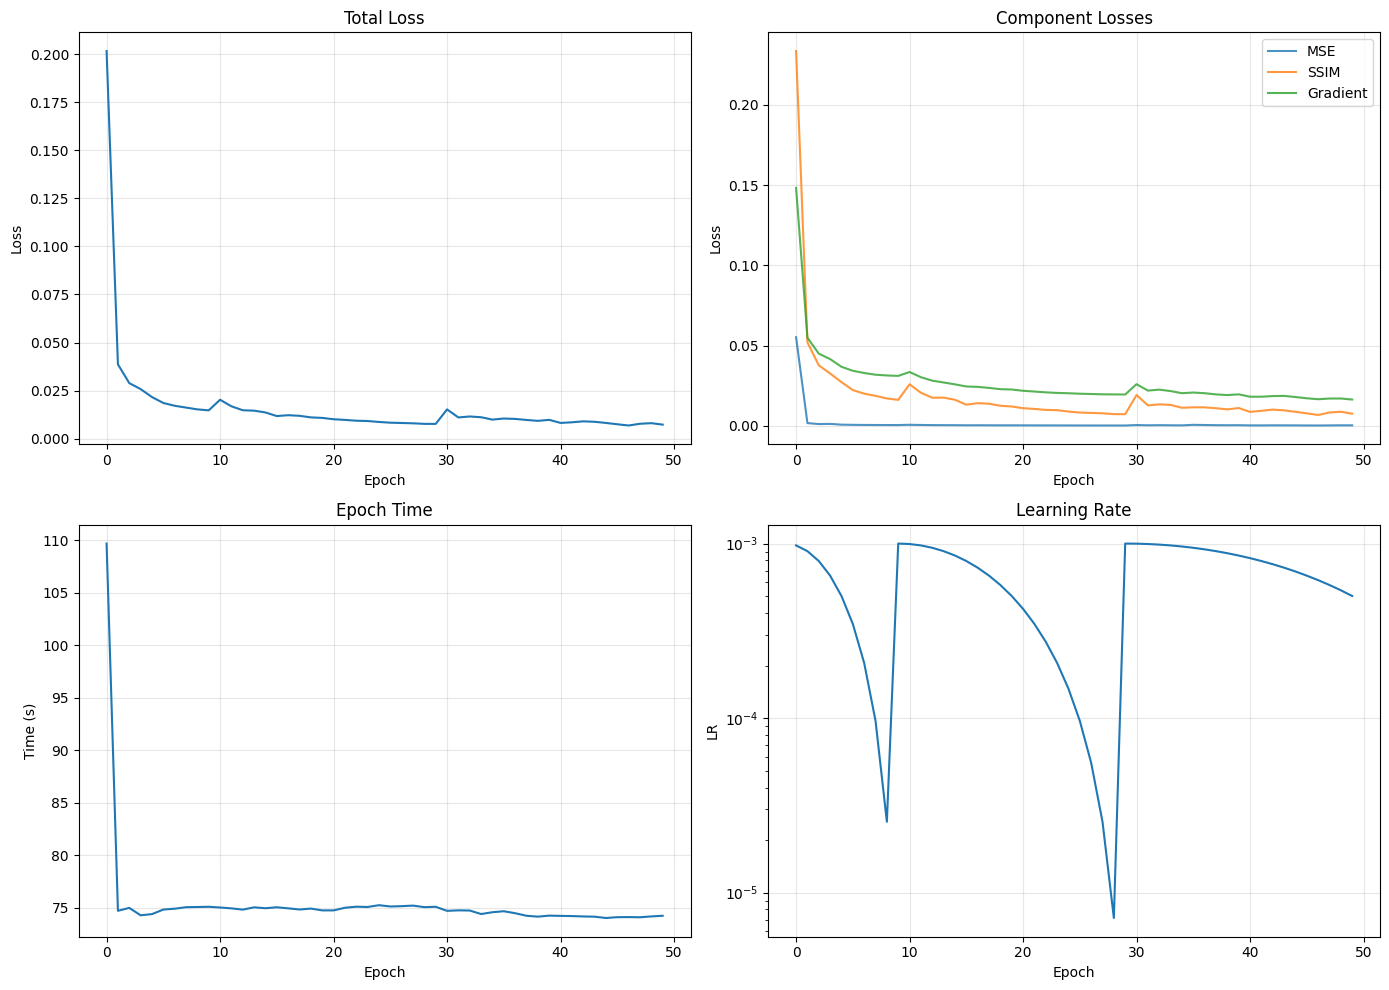

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total loss
axes[0, 0].plot(history['loss'], label='Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].grid(True, alpha=0.3)

# Component losses
axes[0, 1].plot(history['mse'], label='MSE', alpha=0.8)
axes[0, 1].plot(history['ssim'], label='SSIM', alpha=0.8)
axes[0, 1].plot(history['grad'], label='Gradient', alpha=0.8)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Component Losses')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Epoch time
axes[1, 0].plot(history['time'])
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Time (s)')
axes[1, 0].set_title('Epoch Time')
axes[1, 0].grid(True, alpha=0.3)

# Learning rate
axes[1, 1].plot(history['lr'])
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('LR')
axes[1, 1].set_title('Learning Rate')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=150)
plt.show()

In [21]:
@torch.no_grad()
def compute_reconstruction_scores(model, tensors, frame_info, batch_size=128):
    """Per-frame reconstruction MSE."""
    model.eval()
    scores = {}
    n = len(tensors)
    
    for start in tqdm(range(0, n, batch_size), desc="Reconstruction"):
        end = min(start + batch_size, n)
        batch = tensors[start:end]
        recon = model(batch)
        
        mse = torch.mean((batch - recon) ** 2, dim=(1, 2, 3))
        
        for i, score in enumerate(mse.cpu().numpy()):
            vid, fnum = frame_info[start + i]
            scores[f"{vid}_{fnum}"] = float(score)
    
    return scores

recon_scores = compute_reconstruction_scores(model, test_tensors, test_info)
print(f"Reconstruction scores: {len(recon_scores)}")

Reconstruction:   0%|          | 0/92 [00:00<?, ?it/s]

Reconstruction scores: 11706


In [22]:
@torch.no_grad()
def compute_gradient_scores(model, tensors, frame_info, batch_size=128):
    """Per-frame gradient reconstruction error."""
    model.eval()
    scores = {}
    n = len(tensors)
    
    for start in tqdm(range(0, n, batch_size), desc="Gradient"):
        end = min(start + batch_size, n)
        batch = tensors[start:end]
        recon = model(batch)
        
        # Compute gradients
        batch_dx = batch[:, :, :, 1:] - batch[:, :, :, :-1]
        batch_dy = batch[:, :, 1:, :] - batch[:, :, :-1, :]
        recon_dx = recon[:, :, :, 1:] - recon[:, :, :, :-1]
        recon_dy = recon[:, :, 1:, :] - recon[:, :, :-1, :]
        
        grad_err = (torch.mean((batch_dx - recon_dx) ** 2, dim=(1, 2, 3)) +
                    torch.mean((batch_dy - recon_dy) ** 2, dim=(1, 2, 3)))
        
        for i, score in enumerate(grad_err.cpu().numpy()):
            vid, fnum = frame_info[start + i]
            scores[f"{vid}_{fnum}"] = float(score)
    
    return scores

gradient_scores = compute_gradient_scores(model, test_tensors, test_info)
print(f"Gradient scores: {len(gradient_scores)}")

Gradient:   0%|          | 0/92 [00:00<?, ?it/s]

Gradient scores: 11706


In [23]:
@torch.no_grad()
def compute_ssim_scores(model, tensors, frame_info, batch_size=64):
    """Per-frame SSIM error."""
    model.eval()
    ssim_loss = SSIMLoss().to(DEVICE)
    scores = {}
    n = len(tensors)
    
    for start in tqdm(range(0, n, batch_size), desc="SSIM"):
        end = min(start + batch_size, n)
        batch = tensors[start:end]
        recon = model(batch)
        
        # Compute per-image SSIM (need to do individually)
        for i in range(len(batch)):
            ssim_err = ssim_loss(batch[i:i+1], recon[i:i+1])
            vid, fnum = frame_info[start + i]
            scores[f"{vid}_{fnum}"] = float(ssim_err.cpu())
    
    return scores

ssim_scores = compute_ssim_scores(model, test_tensors, test_info)
print(f"SSIM scores: {len(ssim_scores)}")

SSIM:   0%|          | 0/183 [00:00<?, ?it/s]

SSIM scores: 11706


In [24]:
def compute_temporal_scores(recon_scores, test_frames, window=5):
    """Score based on deviation from local temporal neighborhood."""
    scores = {}
    
    for vid in sorted(test_frames.keys()):
        fnums = sorted([f[0] for f in test_frames[vid]])
        errs = [recon_scores.get(f"{vid}_{fn}", 0) for fn in fnums]
        
        for i, fn in enumerate(fnums):
            start = max(0, i - window)
            end = min(len(fnums), i + window + 1)
            
            neighbors = [errs[j] for j in range(start, end) if j != i]
            
            if len(neighbors) >= 2:
                mean_n = np.mean(neighbors)
                std_n = np.std(neighbors) + 1e-8
                z = abs(errs[i] - mean_n) / std_n
                scores[f"{vid}_{fn}"] = z
            else:
                scores[f"{vid}_{fn}"] = 0.0
    
    return scores

temporal_scores = compute_temporal_scores(recon_scores, test_frames, CONFIG['temporal_window'])
print(f"Temporal scores: {len(temporal_scores)}")

Temporal scores: 11706


In [25]:
expected = set(test_frame_ids)

print("Score coverage:")
print(f"  Expected: {len(expected)}")
print(f"  Recon: {len(recon_scores)} | Missing: {len(expected - set(recon_scores.keys()))}")
print(f"  Gradient: {len(gradient_scores)} | Missing: {len(expected - set(gradient_scores.keys()))}")
print(f"  SSIM: {len(ssim_scores)} | Missing: {len(expected - set(ssim_scores.keys()))}")
print(f"  Temporal: {len(temporal_scores)} | Missing: {len(expected - set(temporal_scores.keys()))}")

all_ok = all(set(s.keys()) == expected for s in [recon_scores, gradient_scores, ssim_scores, temporal_scores])
print(f"\n{'✓' if all_ok else '✗'} All frames covered")

Score coverage:
  Expected: 11706
  Recon: 11706 | Missing: 0
  Gradient: 11706 | Missing: 0
  SSIM: 11706 | Missing: 0
  Temporal: 11706 | Missing: 0

✓ All frames covered


In [26]:
def normalize(scores):
    vals = np.array(list(scores.values()))
    keys = list(scores.keys())
    v_min, v_max = vals.min(), vals.max()
    
    if v_max - v_min > 1e-8:
        norm = (vals - v_min) / (v_max - v_min)
    else:
        norm = np.ones_like(vals) * 0.5
    
    return {k: float(norm[i]) for i, k in enumerate(keys)}

# Normalize all
recon_norm = normalize(recon_scores)
gradient_norm = normalize(gradient_scores)
ssim_norm = normalize(ssim_scores)
temporal_norm = normalize(temporal_scores)

print("Normalized scores ready")

Normalized scores ready


In [27]:
FUSION_STRATEGIES = {
    'recon_only': {'recon': 1.0, 'gradient': 0.0, 'ssim': 0.0, 'temporal': 0.0},
    'balanced': {'recon': 0.35, 'gradient': 0.25, 'ssim': 0.25, 'temporal': 0.15},
    'visual_heavy': {'recon': 0.4, 'gradient': 0.3, 'ssim': 0.2, 'temporal': 0.1},
    'ssim_heavy': {'recon': 0.3, 'gradient': 0.2, 'ssim': 0.4, 'temporal': 0.1},
    'no_temporal': {'recon': 0.4, 'gradient': 0.3, 'ssim': 0.3, 'temporal': 0.0},
    'temporal_boost': {'recon': 0.3, 'gradient': 0.2, 'ssim': 0.2, 'temporal': 0.3},
}

print("Fusion strategies defined:")
for name, weights in FUSION_STRATEGIES.items():
    print(f"  {name}: {weights}")

Fusion strategies defined:
  recon_only: {'recon': 1.0, 'gradient': 0.0, 'ssim': 0.0, 'temporal': 0.0}
  balanced: {'recon': 0.35, 'gradient': 0.25, 'ssim': 0.25, 'temporal': 0.15}
  visual_heavy: {'recon': 0.4, 'gradient': 0.3, 'ssim': 0.2, 'temporal': 0.1}
  ssim_heavy: {'recon': 0.3, 'gradient': 0.2, 'ssim': 0.4, 'temporal': 0.1}
  no_temporal: {'recon': 0.4, 'gradient': 0.3, 'ssim': 0.3, 'temporal': 0.0}
  temporal_boost: {'recon': 0.3, 'gradient': 0.2, 'ssim': 0.2, 'temporal': 0.3}


In [28]:
def fuse(recon, gradient, ssim, temporal, weights):
    fused = {}
    for fid in recon.keys():
        fused[fid] = (
            weights['recon'] * recon[fid] +
            weights['gradient'] * gradient.get(fid, 0) +
            weights['ssim'] * ssim.get(fid, 0) +
            weights['temporal'] * temporal.get(fid, 0)
        )
    return normalize(fused)

# Generate all fused scores
fused_scores = {}
for name, weights in FUSION_STRATEGIES.items():
    fused_scores[name] = fuse(recon_norm, gradient_norm, ssim_norm, temporal_norm, weights)
    print(f"Generated: {name}")

Generated: recon_only
Generated: balanced
Generated: visual_heavy
Generated: ssim_heavy
Generated: no_temporal
Generated: temporal_boost


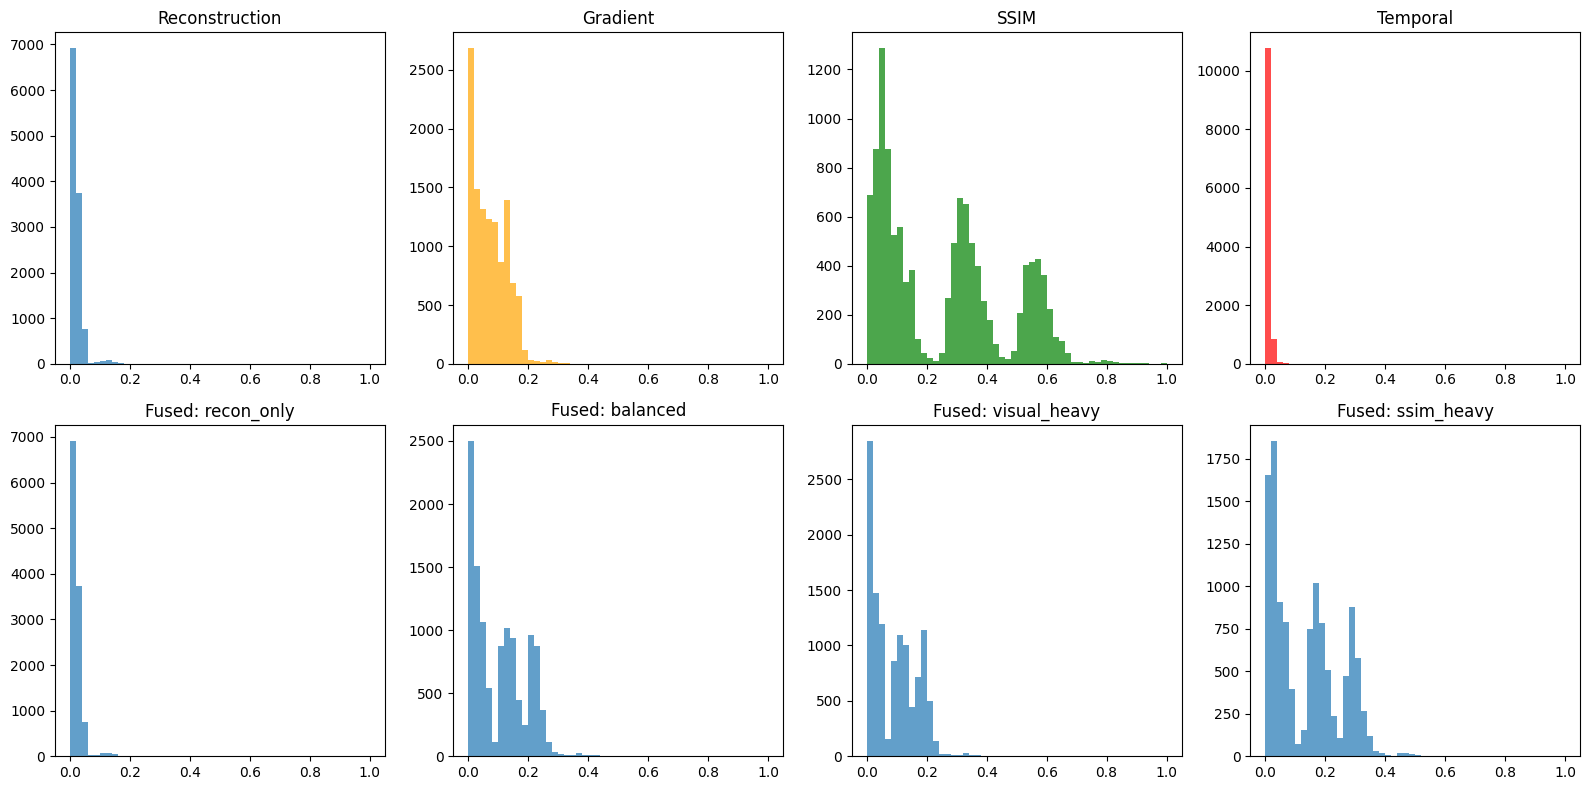

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Individual scores
axes[0, 0].hist(list(recon_norm.values()), bins=50, alpha=0.7)
axes[0, 0].set_title('Reconstruction')

axes[0, 1].hist(list(gradient_norm.values()), bins=50, alpha=0.7, color='orange')
axes[0, 1].set_title('Gradient')

axes[0, 2].hist(list(ssim_norm.values()), bins=50, alpha=0.7, color='green')
axes[0, 2].set_title('SSIM')

axes[0, 3].hist(list(temporal_norm.values()), bins=50, alpha=0.7, color='red')
axes[0, 3].set_title('Temporal')

# Fused scores
for idx, (name, scores) in enumerate(list(fused_scores.items())[:4]):
    axes[1, idx].hist(list(scores.values()), bins=50, alpha=0.7)
    axes[1, idx].set_title(f'Fused: {name}')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'score_distributions.png'), dpi=150)
plt.show()

In [30]:
def save_submission(scores, ids, filename):
    df = pd.DataFrame([{'Id': fid, 'Predicted': scores.get(fid, 0)} for fid in ids])
    path = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(path, index=False)
    return df

submissions = {}

# Individual scores
submissions['recon'] = save_submission(recon_norm, test_frame_ids, 'sub_recon.csv')
submissions['gradient'] = save_submission(gradient_norm, test_frame_ids, 'sub_gradient.csv')
submissions['ssim'] = save_submission(ssim_norm, test_frame_ids, 'sub_ssim.csv')

# Fused scores
for name, scores in fused_scores.items():
    submissions[name] = save_submission(scores, test_frame_ids, f'sub_{name}.csv')

print(f"\nGenerated {len(submissions)} submission files:")
for name in submissions.keys():
    print(f"  sub_{name}.csv")


Generated 9 submission files:
  sub_recon.csv
  sub_gradient.csv
  sub_ssim.csv
  sub_recon_only.csv
  sub_balanced.csv
  sub_visual_heavy.csv
  sub_ssim_heavy.csv
  sub_no_temporal.csv
  sub_temporal_boost.csv


In [31]:
print("Sample from 'balanced' submission:")
print(submissions['balanced'].head(10))
print(f"\nStats:")
print(submissions['balanced']['Predicted'].describe())

Sample from 'balanced' submission:
      Id  Predicted
0  1_939   0.052190
1  1_940   0.053709
2  1_941   0.137241
3  1_942   0.141225
4  1_943   0.243911
5  1_944   0.121451
6  1_945   0.248028
7  1_946   0.143339
8  1_947   0.242976
9  1_948   0.145841

Stats:
count    11706.000000
mean         0.105920
std          0.087759
min          0.000000
25%          0.024515
50%          0.104545
75%          0.167484
max          1.000000
Name: Predicted, dtype: float64


In [32]:
torch.save({
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'history': history,
}, os.path.join(OUTPUT_DIR, 'final_model.pth'))
print("Final model saved!")

Final model saved!


In [33]:
# Free GPU memory
del train_tensors, test_tensors
gc.collect()
torch.cuda.empty_cache()

print(f"GPU memory after cleanup: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print("\n✓ Done!")

GPU memory after cleanup: 4.71 GB

✓ Done!
